In [13]:
from datetime import datetime, timedelta
import os
import h5py
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import colors
import pandas as pd

# Standard library imports
import sys
from mpl_toolkits.basemap import Basemap
from pyproj import CRS

# Modify the system path to include directories containing custom modules
module_code_path = 'C:/Users/lissn/Thesis/code'
sys.path.append(module_code_path)

# Custom module imports
import jowi_functions as jf
#import plot_func as pf
import project_functions as pf

from matplotlib.colors import LogNorm
import matplotlib.lines as mlines
# Local application/library specific imports
import importlib
import project_functions as pf

# Reloading the local module 
importlib.reload(pf)


<module 'project_functions' from 'C:\\Users/lissn/Thesis/code\\project_functions.py'>

In [5]:
# Radar file paths
def generate_file_paths(start_date, end_date, data_dir):
    # Generate a list of dates between start_date and end_date
    start = datetime.strptime(start_date, '%Y%m%d')
    end = datetime.strptime(end_date, '%Y%m%d')
    date_list = [start + timedelta(days=x) for x in range((end-start).days + 1)]

    file_paths = []
    for date in date_list:
        year = date.strftime('%Y')
        month = date.strftime('%m')
        day = date.strftime('%d')
        for hour in range(24):
            for minute in range(0, 60, 10):  # Assuming every 10 minutes
                time = f'{hour:02d}{minute:02d}'
                file_path = f"{data_dir}/{year}/{year}/{month}/{day}/dk.com.{year}{month}{day}{time}.500_max.h5"
                if os.path.exists(file_path):  # Check if the file actually exists
                    file_paths.append(file_path)
    return file_paths

# Example usage
data_dir = "C:/Users/lissn/Thesis/data/radar"
start_date = '20220402'  # Start date
end_date = '20230401'    # End date
file_paths = generate_file_paths(start_date, end_date, data_dir)

In [6]:
print('Number of files: \t', len(file_paths))
print('Number of missing files: \t', 6*24*365 - len(file_paths))

Number of files: 	 52494
Number of missing files: 	 66


In [7]:
img_height = 1728
img_width = 1984

total_val = np.zeros((img_height, img_width))
total_sq_val = np.zeros((img_height, img_width))  

error_count = 0

for file_path in tqdm(file_paths, desc="Processing files"):
    try:
        with h5py.File(file_path, 'r') as f:
            raw_data = f['dataset1/data1/data'][()]
            raw_data_array = np.array(raw_data).astype(float)
            raw_data_array[raw_data_array == 255] = 0 #np.nan # values of 255 in raw data are actually NaN
            zero_values = raw_data_array == 0 # store where zero values are located in the grid, as these are changed by the transformation below
            gain = 0.5
            offset = -32
            dbz_data = offset + gain * raw_data_array # convert to dBZ
            dbz_data[zero_values] = 0 #np.nan
            total_val += dbz_data
            total_sq_val += dbz_data ** 2 
    except:
        print(f"Error reading file: {file_path}")
        error_count += 1

n_files = len(file_paths) - error_count 

# Compute average
average_val = total_val / n_files

# Compute variance
variance_val = (total_sq_val / n_files) - (average_val ** 2)

Processing files: 100%|██████████| 52494/52494 [1:37:09<00:00,  9.01it/s]  


In [8]:

dbz_data_with_nan = np.where(average_val == 0, np.nan, average_val)
variance_dbz_data_with_nan = np.where(variance_val == 0, np.nan, variance_val)


In [14]:
# Radar coordinates
scale_factor = 1
x_radar_start = -421364.8 - 500/scale_factor
x_radar_end = 569635.2 + 500/scale_factor
y_radar_start = 468631 + 500/scale_factor
y_radar_end = -394369 - 500/scale_factor
x_radar_spacing = 500/scale_factor
y_radar_spacing = -500/scale_factor

# Generate radar coordinates to match the projected grid 
x_radar_coords = np.arange(x_radar_start, x_radar_end + x_radar_spacing, x_radar_spacing)
y_radar_coords = np.arange(y_radar_start, y_radar_end + y_radar_spacing, y_radar_spacing)

# CRS definitions
dmi_stere_crs = CRS("+proj=stere +ellps=WGS84 +lat_0=56 +lon_0=10.5666 +lat_ts=56") # raw data CRS projection
plotting_crs = 'epsg:4326' # the CRS projection you want to plot the data in

# Project the coordinates to the target CRS efficiently
radar_lons, radar_lats = jf.project_raster_coords(x_radar_coords, y_radar_coords, dmi_stere_crs, plotting_crs)


radar_path = 'C:/Users/lissn/Thesis/data/meta_data/radar_meta_data.csv' 
radar_df = pd.read_csv(radar_path)

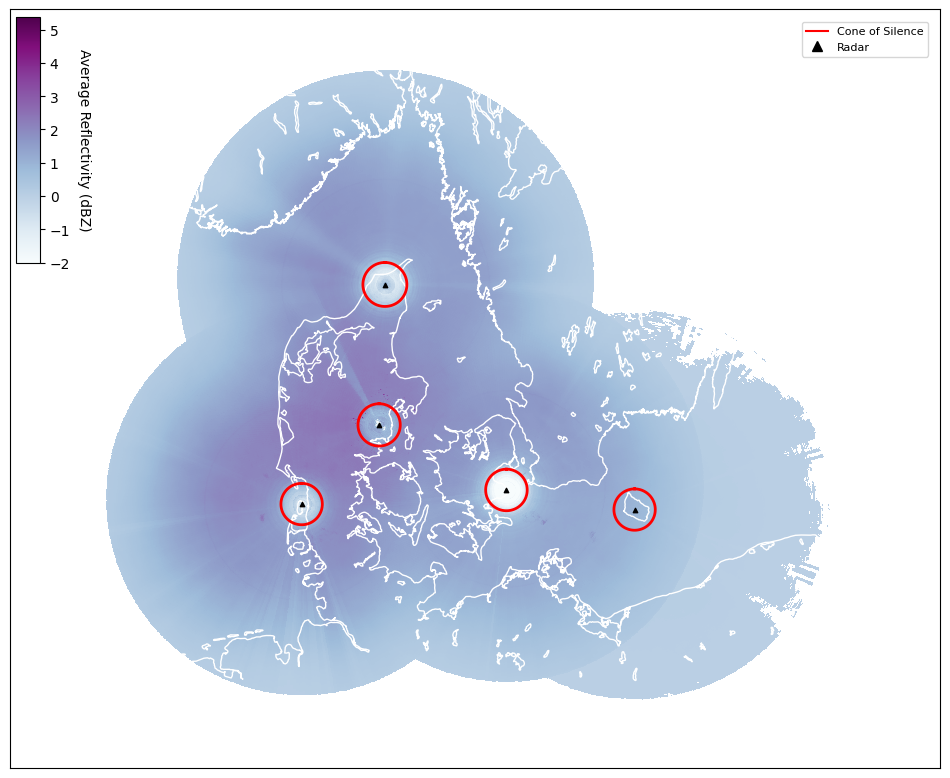

In [15]:
# Create figure
fig, ax = plt.subplots(figsize=(12, 12))

# Define latitude and longitude boundaries for Denmark
llcrnrlat = 52.2    # lower latitude
urcrnrlat = 60.2   # upper latitude
llcrnrlon = 3.0      # lower longitude
urcrnrlon = 20.7     # upper longitude

# Create a Basemap instance
m = Basemap(projection='merc', llcrnrlat=llcrnrlat, urcrnrlat=urcrnrlat, llcrnrlon=llcrnrlon, urcrnrlon=urcrnrlon, lat_ts=0, resolution='h')

x, y = m(radar_lons, radar_lats) 
colormesh = plt.pcolormesh(x, y, dbz_data_with_nan, cmap='BuPu', vmin = -2)#, norm=LogNorm(vmin=0.01, vmax=total_val.max()))

# Add radars and circle 
for idx, row in radar_df.iterrows():
    x, y = m(row['Longitude'], row['Latitude'])
    m.scatter(x, y, marker="^", color='black', zorder=5, s = 10)
    pf.draw_circle(m, row['Longitude'], row['Latitude'], 25, 'red', 2)

# Add coastline
m.drawcoastlines(color = "white")

# Add color bar
left, bottom, width, height = [0.13, 0.6, 0.02, 0.205]
ax_inset = fig.add_axes([left, bottom, width, height])
cbar = plt.colorbar(colormesh, cax=ax_inset, orientation='vertical')
cbar.set_label('Average Reflectivity (dBZ)', rotation=270, labelpad=15)

cone = mlines.Line2D([], [], color='red', marker=None, linestyle='-',
                                         markersize=None, label='Cone of Silence')
radar_marker = mlines.Line2D([], [], color='black', marker='^', linestyle='None',
                                 markersize=7, label='Radar')

    
plt.legend(handles=[cone, radar_marker], 
           loc='upper right', bbox_to_anchor=(38.25, 1), fontsize=8, markerscale=1)

save_path = 'C:/Users/lissn/Thesis/figures/total_radar_map.png'
plt.savefig(save_path, bbox_inches='tight', pad_inches=0.01, dpi=300)
plt.show()

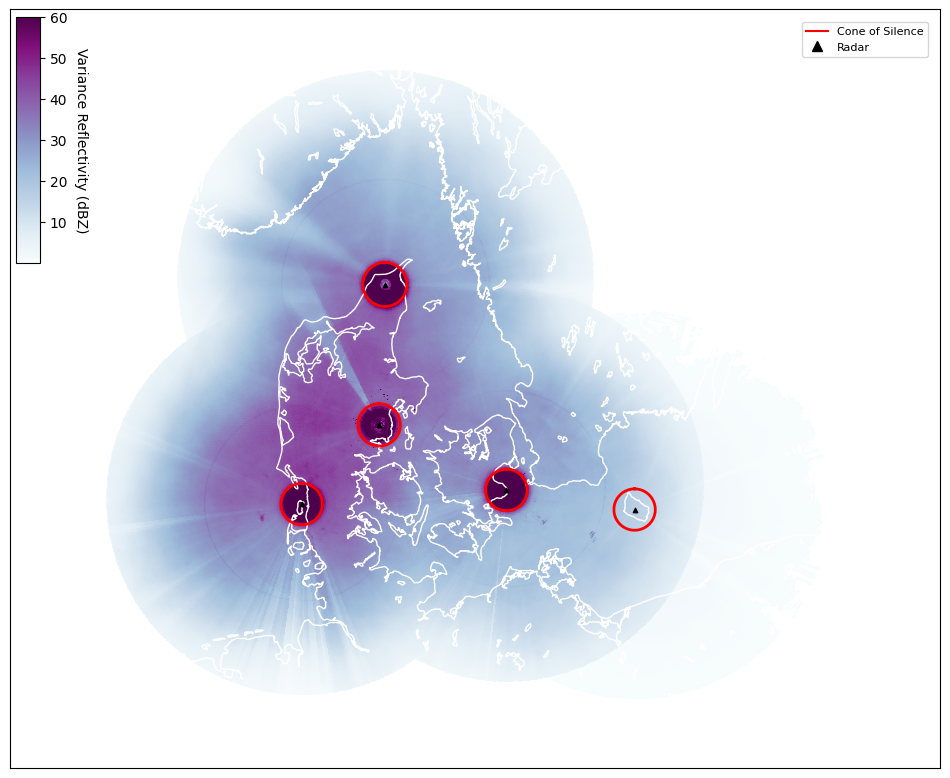

In [21]:
# Create figure
fig, ax = plt.subplots(figsize=(12, 12))

# Define latitude and longitude boundaries for Denmark
llcrnrlat = 52.2    # lower latitude
urcrnrlat = 60.2   # upper latitude
llcrnrlon = 3.0      # lower longitude
urcrnrlon = 20.7     # upper longitude

# Create a Basemap instance
m = Basemap(projection='merc', llcrnrlat=llcrnrlat, urcrnrlat=urcrnrlat, llcrnrlon=llcrnrlon, urcrnrlon=urcrnrlon, lat_ts=0, resolution='h')

x, y = m(radar_lons, radar_lats) 
colormesh = plt.pcolormesh(x, y, variance_dbz_data_with_nan, cmap='BuPu', vmax = 60)#, norm=LogNorm(vmin=0.01, vmax=total_val.max()))

# Add radars and circle 
for idx, row in radar_df.iterrows():
    x, y = m(row['Longitude'], row['Latitude'])
    m.scatter(x, y, marker="^", color='black', zorder=5, s = 10)
    pf.draw_circle(m, row['Longitude'], row['Latitude'], 25, 'red', 2)

# Add coastline
m.drawcoastlines(color = "white")

# Add color bar
left, bottom, width, height = [0.13, 0.6, 0.02, 0.205]
ax_inset = fig.add_axes([left, bottom, width, height])
cbar = plt.colorbar(colormesh, cax=ax_inset, orientation='vertical')
cbar.set_label('Variance Reflectivity (dBZ)', rotation=270, labelpad=15)

cone = mlines.Line2D([], [], color='red', marker=None, linestyle='-',
                                         markersize=None, label='Cone of Silence')
radar_marker = mlines.Line2D([], [], color='black', marker='^', linestyle='None',
                                 markersize=7, label='Radar')

    
plt.legend(handles=[cone, radar_marker], 
                     loc='upper right', bbox_to_anchor=(38.25, 1), fontsize=8, markerscale=1)

save_path = 'C:/Users/lissn/Thesis/figures/total_radar_map_var.png'
plt.savefig(save_path, bbox_inches='tight', pad_inches=0.01, dpi=300)
plt.show()